In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
from datetime import datetime
import talib
import talib.abstract as tabs

In [2]:
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
tickets = first_table['Symbol'].values.tolist()
tickets.remove('BRK.B')
tickets.remove('BF.B')

In [36]:
all_stocks = []
for ticket in tickets:
    stocks = pd.read_csv('../datasets/enriched/' + ticket + '.csv')
    all_stocks.append(stocks)

In [37]:
dataset = pd.concat(all_stocks, axis=0)
dataset

,high,low,open,close,volume,adj close,roc,sma,macd,macd_signal,...,upper,middle,bbands,sar,bop,dx,plus_di,willr,trix,obv
0,206.789993,202.190002,202.869995,206.570007,2623000.0,191.088211,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.804352,0.000000,0.000000,0.000000,0.000000,2623000.0
1,210.399994,206.589996,207.089996,209.720001,2967300.0,194.002090,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,202.190002,0.690290,0.000000,0.000000,0.000000,0.000000,5590300.0
2,207.119995,204.050003,206.589996,204.929993,2229700.0,190.881744,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,202.354202,-0.540719,0.000000,0.000000,0.000000,0.000000,3360600.0
3,208.970001,206.000000,206.460007,208.860001,2000400.0,194.542313,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,202.515118,0.808078,0.000000,0.000000,0.000000,0.000000,5361000.0
4,209.149994,207.389999,207.910004,208.410004,1534400.0,194.123199,0.000000,0.0000,0.000000,0.000000,...,211.148209,207.698001,204.247793,202.672816,0.284092,0.000000,0.000000,0.000000,0.000000,3826600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,161.889999,158.500000,160.399994,160.020004,1625100.0,160.020004,-0.818143,156.8270,-1.440415,-1.428655,...,161.197062,157.810001,154.422939,152.459203,-0.112091,1.038776,24.310944,-42.602208,-0.014122,92585800.0
502,161.789993,159.009995,159.809998,159.830002,1852700.0,159.830002,0.075133,156.8390,-1.227758,-1.388476,...,161.991619,158.298001,154.604384,152.836435,0.007196,1.038776,22.935338,-44.014866,-0.017580,90733100.0
503,162.729996,160.169998,161.250000,160.619995,1746000.0,160.619995,4.877572,157.5860,-0.984136,-1.307608,...,161.779680,159.376001,156.972322,153.198577,-0.246096,3.261446,23.501850,-35.503907,-0.020461,92479100.0
504,164.729996,160.399994,161.149994,164.440002,1860300.0,164.440002,5.053347,158.3770,-0.477318,-1.141550,...,164.540377,160.838000,157.135624,153.770462,0.759817,11.857044,25.491037,-2.333013,-0.022198,94339400.0


In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [45]:
NUM_FEATURES = 28

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components = NUM_FEATURES)
pca.fit(dataset)

PCA(copy=True, iterated_power='auto', n_components=28, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [47]:
pca.explained_variance_ratio_

array([5.00828193e-01, 1.37384344e-01, 1.18813024e-01, 8.66668586e-02,
       4.44239438e-02, 4.40301082e-02, 2.74086091e-02, 1.36273329e-02,
       7.53709179e-03, 6.06437296e-03, 4.49598765e-03, 4.38854661e-03,
       1.58880760e-03, 9.73996483e-04, 8.70225155e-04, 3.37297239e-04,
       2.97900365e-04, 1.31793580e-04, 7.52389828e-05, 2.62161662e-05,
       1.11050940e-05, 8.15611136e-06, 5.88874473e-06, 3.19930610e-06,
       1.03429581e-06, 3.73923390e-07, 2.53440749e-07, 1.01428238e-07])

In [48]:
def prepare_data(X, close, timerange=10):
    
    x = np.ndarray(shape=(X.shape[0] - timerange, timerange, X.shape[1]))
    y = np.ndarray(shape=(x.shape[0]))
    for i in range(x.shape[0]):
        x[i] = X[i:i+timerange]
        y[i] = 1 if close[i+timerange-1] < close[i+timerange] else 0
    
    return x, y

In [53]:
import random
TRAIN_SPLIT = 0.7
VALIDATION_SPLIT = 0.1
random.shuffle(all_stocks)
TRAIN_SIZE = int(len(all_stocks) * TRAIN_SPLIT)
VALIDATION_SIZE = int(len(all_stocks) * VALIDATION_SPLIT)

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

histories = []
NUM_EPOCHS=100
BATCH_SIZE=256

for TIMERANGE in range(2, 21):
    
    X_train, X_test = [np.ndarray(shape=(0, TIMERANGE, NUM_FEATURES)) for i in range(2)]
    Y_train, Y_test = [np.ndarray(shape=(0)) for i in range(2)]
    
    for stock in all_stocks[:train_size]:
        X = scaler.transform(stock)
        X = pca.transform(X)
        x_train, y_train = prepare_data(X, stock['close'], timerange=TIMERANGE)
        X_train = np.append(X_train, x_train, axis=0)
        Y_train = np.append(Y_train, y_train, axis=0)

    for stock in all_stocks[train_size:]:
        X = scaler.transform(stock)
        X = pca.transform(X)
        x_test, y_test = prepare_data(X, stock['close'], timerange=TIMERANGE)
        X_test = np.append(X_test, x_test, axis=0)
        Y_test = np.append(Y_test, y_test, axis=0)

    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(0.001), metrics=['accuracy'])
    
    checkpoint_filepath = '../models/balanced-split/lstm-timernage-' + str(TIMERANGE)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    history = model.fit(
        X_train,
        Y_train,
        validation_split=0.1,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[model_checkpoint_callback])
    
    histories.append(history)
    
    model.load_weights(checkpoint_filepath)
    
    print('model evaluation: ', model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE))
    

Epoch 1/100
707/707 [==============================] - 3s 5ms/step - loss: 0.2589 - accuracy: 0.5125 - val_loss: 0.2487 - val_accuracy: 0.5321
Epoch 2/100
707/707 [==============================] - 3s 4ms/step - loss: 0.2501 - accuracy: 0.5195 - val_loss: 0.2486 - val_accuracy: 0.5305
Epoch 3/100
707/707 [==============================] - 3s 4ms/step - loss: 0.2498 - accuracy: 0.5222 - val_loss: 0.2487 - val_accuracy: 0.5336
Epoch 4/100
707/707 [==============================] - 4s 5ms/step - loss: 0.2493 - accuracy: 0.5250 - val_loss: 0.2483 - val_accuracy: 0.5388
Epoch 5/100
707/707 [==============================] - 7s 10ms/step - loss: 0.2486 - accuracy: 0.5305 - val_loss: 0.2492 - val_accuracy: 0.5350
Epoch 6/100
707/707 [==============================] - 6s 8ms/step - loss: 0.2484 - accuracy: 0.5322 - val_loss: 0.2485 - val_accuracy: 0.5383
Epoch 7/100
707/707 [==============================] - 8s 11ms/step - loss: 0.2483 - accuracy: 0.5329 - val_loss: 0.2483 - val_accuracy: 0.53

Epoch 58/100
707/707 [==============================] - 8s 11ms/step - loss: 0.2441 - accuracy: 0.5514 - val_loss: 0.2451 - val_accuracy: 0.5468
Epoch 59/100
707/707 [==============================] - 9s 12ms/step - loss: 0.2440 - accuracy: 0.5511 - val_loss: 0.2452 - val_accuracy: 0.5458
Epoch 60/100
707/707 [==============================] - 3s 5ms/step - loss: 0.2440 - accuracy: 0.5519 - val_loss: 0.2449 - val_accuracy: 0.5489
Epoch 61/100
707/707 [==============================] - 3s 4ms/step - loss: 0.2438 - accuracy: 0.5524 - val_loss: 0.2448 - val_accuracy: 0.5490
Epoch 62/100
707/707 [==============================] - 3s 4ms/step - loss: 0.2438 - accuracy: 0.5520 - val_loss: 0.2445 - val_accuracy: 0.5503
Epoch 63/100
707/707 [==============================] - 4s 5ms/step - loss: 0.2437 - accuracy: 0.5528 - val_loss: 0.2450 - val_accuracy: 0.5477
Epoch 64/100
707/707 [==============================] - 4s 5ms/step - loss: 0.2437 - accuracy: 0.5526 - val_loss: 0.2447 - val_accurac

Epoch 14/100
706/706 [==============================] - 5s 7ms/step - loss: 0.2466 - accuracy: 0.5407 - val_loss: 0.2470 - val_accuracy: 0.5450
Epoch 15/100
706/706 [==============================] - 5s 7ms/step - loss: 0.2464 - accuracy: 0.5421 - val_loss: 0.2466 - val_accuracy: 0.5448
Epoch 16/100
706/706 [==============================] - 5s 7ms/step - loss: 0.2461 - accuracy: 0.5431 - val_loss: 0.2467 - val_accuracy: 0.5457
Epoch 17/100
706/706 [==============================] - 5s 7ms/step - loss: 0.2459 - accuracy: 0.5442 - val_loss: 0.2462 - val_accuracy: 0.5481
Epoch 18/100
706/706 [==============================] - 5s 7ms/step - loss: 0.2456 - accuracy: 0.5448 - val_loss: 0.2458 - val_accuracy: 0.5517
Epoch 19/100
706/706 [==============================] - 5s 7ms/step - loss: 0.2455 - accuracy: 0.5466 - val_loss: 0.2457 - val_accuracy: 0.5476
Epoch 20/100
706/706 [==============================] - 5s 7ms/step - loss: 0.2453 - accuracy: 0.5462 - val_loss: 0.2455 - val_accuracy:

Epoch 71/100
706/706 [==============================] - 5s 8ms/step - loss: 0.2377 - accuracy: 0.5751 - val_loss: 0.2408 - val_accuracy: 0.5635
Epoch 72/100
706/706 [==============================] - 5s 7ms/step - loss: 0.2377 - accuracy: 0.5753 - val_loss: 0.2409 - val_accuracy: 0.5667
Epoch 73/100
706/706 [==============================] - 5s 7ms/step - loss: 0.2375 - accuracy: 0.5751 - val_loss: 0.2409 - val_accuracy: 0.5678
Epoch 74/100
706/706 [==============================] - 5s 7ms/step - loss: 0.2374 - accuracy: 0.5761 - val_loss: 0.2412 - val_accuracy: 0.5664
Epoch 75/100
706/706 [==============================] - 12s 17ms/step - loss: 0.2371 - accuracy: 0.5774 - val_loss: 0.2406 - val_accuracy: 0.5643
Epoch 76/100
706/706 [==============================] - 7s 10ms/step - loss: 0.2371 - accuracy: 0.5769 - val_loss: 0.2404 - val_accuracy: 0.5678
Epoch 77/100
706/706 [==============================] - 5s 7ms/step - loss: 0.2370 - accuracy: 0.5766 - val_loss: 0.2404 - val_accura

Epoch 27/100
704/704 [==============================] - 6s 9ms/step - loss: 0.2418 - accuracy: 0.5602 - val_loss: 0.2426 - val_accuracy: 0.5568
Epoch 28/100
704/704 [==============================] - 6s 9ms/step - loss: 0.2417 - accuracy: 0.5604 - val_loss: 0.2425 - val_accuracy: 0.5584
Epoch 29/100
704/704 [==============================] - 6s 9ms/step - loss: 0.2414 - accuracy: 0.5617 - val_loss: 0.2426 - val_accuracy: 0.5569
Epoch 30/100
704/704 [==============================] - 6s 9ms/step - loss: 0.2412 - accuracy: 0.5611 - val_loss: 0.2424 - val_accuracy: 0.5579
Epoch 31/100
704/704 [==============================] - 6s 9ms/step - loss: 0.2410 - accuracy: 0.5622 - val_loss: 0.2424 - val_accuracy: 0.5579
Epoch 32/100
704/704 [==============================] - 9s 13ms/step - loss: 0.2407 - accuracy: 0.5628 - val_loss: 0.2422 - val_accuracy: 0.5584
Epoch 33/100
704/704 [==============================] - 10s 15ms/step - loss: 0.2404 - accuracy: 0.5638 - val_loss: 0.2419 - val_accura

Epoch 84/100
704/704 [==============================] - 6s 9ms/step - loss: 0.2314 - accuracy: 0.5921 - val_loss: 0.2376 - val_accuracy: 0.5732
Epoch 85/100
704/704 [==============================] - 10s 14ms/step - loss: 0.2313 - accuracy: 0.5919 - val_loss: 0.2388 - val_accuracy: 0.5704
Epoch 86/100
704/704 [==============================] - 5s 8ms/step - loss: 0.2311 - accuracy: 0.5928 - val_loss: 0.2387 - val_accuracy: 0.5699
Epoch 87/100
704/704 [==============================] - 6s 9ms/step - loss: 0.2310 - accuracy: 0.5937 - val_loss: 0.2383 - val_accuracy: 0.5738
Epoch 88/100
704/704 [==============================] - 6s 9ms/step - loss: 0.2308 - accuracy: 0.5936 - val_loss: 0.2381 - val_accuracy: 0.5726
Epoch 89/100
704/704 [==============================] - 6s 9ms/step - loss: 0.2308 - accuracy: 0.5931 - val_loss: 0.2381 - val_accuracy: 0.5716
Epoch 90/100
704/704 [==============================] - 6s 9ms/step - loss: 0.2305 - accuracy: 0.5948 - val_loss: 0.2374 - val_accurac

703/703 [==============================] - 7s 10ms/step - loss: 0.2363 - accuracy: 0.5769 - val_loss: 0.2398 - val_accuracy: 0.5633
Epoch 40/100
703/703 [==============================] - 7s 10ms/step - loss: 0.2361 - accuracy: 0.5757 - val_loss: 0.2391 - val_accuracy: 0.5653
Epoch 41/100
703/703 [==============================] - 7s 10ms/step - loss: 0.2358 - accuracy: 0.5791 - val_loss: 0.2388 - val_accuracy: 0.5679
Epoch 42/100
703/703 [==============================] - 7s 10ms/step - loss: 0.2354 - accuracy: 0.5793 - val_loss: 0.2390 - val_accuracy: 0.5666
Epoch 43/100
703/703 [==============================] - 7s 10ms/step - loss: 0.2351 - accuracy: 0.5794 - val_loss: 0.2383 - val_accuracy: 0.5683
Epoch 44/100
703/703 [==============================] - 7s 10ms/step - loss: 0.2349 - accuracy: 0.5802 - val_loss: 0.2379 - val_accuracy: 0.5725
Epoch 45/100
703/703 [==============================] - 7s 10ms/step - loss: 0.2346 - accuracy: 0.5822 - val_loss: 0.2383 - val_accuracy: 0.570

703/703 [==============================] - 7s 10ms/step - loss: 0.2231 - accuracy: 0.6154 - val_loss: 0.2368 - val_accuracy: 0.5797
Epoch 96/100
703/703 [==============================] - 7s 10ms/step - loss: 0.2230 - accuracy: 0.6181 - val_loss: 0.2365 - val_accuracy: 0.5805
Epoch 97/100
703/703 [==============================] - 7s 10ms/step - loss: 0.2230 - accuracy: 0.6162 - val_loss: 0.2362 - val_accuracy: 0.5817
Epoch 98/100
703/703 [==============================] - 7s 10ms/step - loss: 0.2227 - accuracy: 0.6182 - val_loss: 0.2362 - val_accuracy: 0.5823
Epoch 99/100
703/703 [==============================] - 7s 10ms/step - loss: 0.2224 - accuracy: 0.6187 - val_loss: 0.2363 - val_accuracy: 0.5806
Epoch 100/100
198/198 [==============================] - 1s 3ms/step - loss: 0.2335 - accuracy: 0.5892
model evaluation:  [0.2335461676120758, 0.5891621708869934]
Epoch 1/100
702/702 [==============================] - 9s 12ms/step - loss: 0.2555 - accuracy: 0.5153 - val_loss: 0.2489 - va

702/702 [==============================] - 8s 11ms/step - loss: 0.2316 - accuracy: 0.5888 - val_loss: 0.2359 - val_accuracy: 0.5728
Epoch 51/100
702/702 [==============================] - 8s 12ms/step - loss: 0.2315 - accuracy: 0.5904 - val_loss: 0.2356 - val_accuracy: 0.5733
Epoch 52/100
702/702 [==============================] - 9s 13ms/step - loss: 0.2311 - accuracy: 0.5911 - val_loss: 0.2354 - val_accuracy: 0.5766
Epoch 53/100
702/702 [==============================] - 17s 24ms/step - loss: 0.2308 - accuracy: 0.5913 - val_loss: 0.2347 - val_accuracy: 0.5778
Epoch 54/100
702/702 [==============================] - 11s 15ms/step - loss: 0.2306 - accuracy: 0.5928 - val_loss: 0.2349 - val_accuracy: 0.5785
Epoch 55/100
702/702 [==============================] - 7s 10ms/step - loss: 0.2305 - accuracy: 0.5921 - val_loss: 0.2348 - val_accuracy: 0.5767
Epoch 56/100
702/702 [==============================] - 10s 15ms/step - loss: 0.2300 - accuracy: 0.5944 - val_loss: 0.2344 - val_accuracy: 0.

700/700 [==============================] - 9s 13ms/step - loss: 0.2490 - accuracy: 0.5291 - val_loss: 0.2486 - val_accuracy: 0.5310
Epoch 6/100
700/700 [==============================] - 9s 13ms/step - loss: 0.2483 - accuracy: 0.5346 - val_loss: 0.2483 - val_accuracy: 0.5374
Epoch 7/100
700/700 [==============================] - 9s 13ms/step - loss: 0.2477 - accuracy: 0.5377 - val_loss: 0.2479 - val_accuracy: 0.5414
Epoch 8/100
700/700 [==============================] - 9s 13ms/step - loss: 0.2471 - accuracy: 0.5405 - val_loss: 0.2479 - val_accuracy: 0.5351
Epoch 9/100
700/700 [==============================] - 9s 13ms/step - loss: 0.2465 - accuracy: 0.5433 - val_loss: 0.2475 - val_accuracy: 0.5348
Epoch 10/100
700/700 [==============================] - 10s 14ms/step - loss: 0.2460 - accuracy: 0.5439 - val_loss: 0.2465 - val_accuracy: 0.5440
Epoch 11/100
700/700 [==============================] - 10s 14ms/step - loss: 0.2455 - accuracy: 0.5464 - val_loss: 0.2459 - val_accuracy: 0.5464


700/700 [==============================] - 13s 19ms/step - loss: 0.2267 - accuracy: 0.6044 - val_loss: 0.2351 - val_accuracy: 0.5828
Epoch 62/100
700/700 [==============================] - 14s 20ms/step - loss: 0.2261 - accuracy: 0.6054 - val_loss: 0.2344 - val_accuracy: 0.5810
Epoch 63/100
700/700 [==============================] - 15s 22ms/step - loss: 0.2259 - accuracy: 0.6073 - val_loss: 0.2346 - val_accuracy: 0.5799
Epoch 64/100
700/700 [==============================] - 9s 13ms/step - loss: 0.2256 - accuracy: 0.6080 - val_loss: 0.2344 - val_accuracy: 0.5837
Epoch 65/100
700/700 [==============================] - 10s 14ms/step - loss: 0.2254 - accuracy: 0.6088 - val_loss: 0.2346 - val_accuracy: 0.5825
Epoch 66/100
700/700 [==============================] - 11s 15ms/step - loss: 0.2252 - accuracy: 0.6092 - val_loss: 0.2347 - val_accuracy: 0.5829
Epoch 67/100
700/700 [==============================] - 9s 13ms/step - loss: 0.2250 - accuracy: 0.6099 - val_loss: 0.2345 - val_accuracy: 

699/699 [==============================] - 10s 15ms/step - loss: 0.2425 - accuracy: 0.5566 - val_loss: 0.2426 - val_accuracy: 0.5576
Epoch 17/100
699/699 [==============================] - 11s 15ms/step - loss: 0.2418 - accuracy: 0.5578 - val_loss: 0.2427 - val_accuracy: 0.5549
Epoch 18/100
699/699 [==============================] - 12s 17ms/step - loss: 0.2411 - accuracy: 0.5602 - val_loss: 0.2419 - val_accuracy: 0.5597
Epoch 19/100
699/699 [==============================] - 11s 15ms/step - loss: 0.2407 - accuracy: 0.5612 - val_loss: 0.2413 - val_accuracy: 0.5572
Epoch 20/100
699/699 [==============================] - 11s 15ms/step - loss: 0.2400 - accuracy: 0.5630 - val_loss: 0.2413 - val_accuracy: 0.5629
Epoch 21/100
699/699 [==============================] - 11s 15ms/step - loss: 0.2398 - accuracy: 0.5647 - val_loss: 0.2408 - val_accuracy: 0.5606
Epoch 22/100
699/699 [==============================] - 15s 21ms/step - loss: 0.2393 - accuracy: 0.5654 - val_loss: 0.2405 - val_accuracy

699/699 [==============================] - 10s 15ms/step - loss: 0.2211 - accuracy: 0.6189 - val_loss: 0.2363 - val_accuracy: 0.5849
Epoch 73/100
699/699 [==============================] - 11s 15ms/step - loss: 0.2208 - accuracy: 0.6190 - val_loss: 0.2351 - val_accuracy: 0.5840
Epoch 74/100
699/699 [==============================] - 10s 15ms/step - loss: 0.2206 - accuracy: 0.6208 - val_loss: 0.2366 - val_accuracy: 0.5844
Epoch 75/100
699/699 [==============================] - 11s 15ms/step - loss: 0.2203 - accuracy: 0.6207 - val_loss: 0.2358 - val_accuracy: 0.5828
Epoch 76/100
699/699 [==============================] - 11s 15ms/step - loss: 0.2200 - accuracy: 0.6224 - val_loss: 0.2360 - val_accuracy: 0.5855
Epoch 77/100
699/699 [==============================] - 11s 15ms/step - loss: 0.2197 - accuracy: 0.6224 - val_loss: 0.2361 - val_accuracy: 0.5821
Epoch 78/100
699/699 [==============================] - 10s 15ms/step - loss: 0.2195 - accuracy: 0.6228 - val_loss: 0.2358 - val_accuracy

697/697 [==============================] - 11s 16ms/step - loss: 0.2380 - accuracy: 0.5682 - val_loss: 0.2394 - val_accuracy: 0.5590
Epoch 28/100
697/697 [==============================] - 11s 16ms/step - loss: 0.2375 - accuracy: 0.5710 - val_loss: 0.2393 - val_accuracy: 0.5636
Epoch 29/100
697/697 [==============================] - 13s 18ms/step - loss: 0.2369 - accuracy: 0.5700 - val_loss: 0.2389 - val_accuracy: 0.5647
Epoch 30/100
697/697 [==============================] - 19s 27ms/step - loss: 0.2366 - accuracy: 0.5729 - val_loss: 0.2381 - val_accuracy: 0.5668
Epoch 31/100
697/697 [==============================] - 15s 22ms/step - loss: 0.2359 - accuracy: 0.5742 - val_loss: 0.2381 - val_accuracy: 0.5661
Epoch 32/100
697/697 [==============================] - 15s 22ms/step - loss: 0.2357 - accuracy: 0.5750 - val_loss: 0.2380 - val_accuracy: 0.5678
Epoch 33/100
697/697 [==============================] - 11s 15ms/step - loss: 0.2351 - accuracy: 0.5769 - val_loss: 0.2374 - val_accuracy

697/697 [==============================] - 12s 17ms/step - loss: 0.2171 - accuracy: 0.6312 - val_loss: 0.2372 - val_accuracy: 0.5836
Epoch 84/100
697/697 [==============================] - 11s 16ms/step - loss: 0.2168 - accuracy: 0.6311 - val_loss: 0.2359 - val_accuracy: 0.5866
Epoch 85/100
697/697 [==============================] - 12s 17ms/step - loss: 0.2167 - accuracy: 0.6302 - val_loss: 0.2358 - val_accuracy: 0.5855
Epoch 86/100
697/697 [==============================] - 13s 18ms/step - loss: 0.2160 - accuracy: 0.6333 - val_loss: 0.2358 - val_accuracy: 0.5886
Epoch 87/100
697/697 [==============================] - 12s 17ms/step - loss: 0.2161 - accuracy: 0.6332 - val_loss: 0.2356 - val_accuracy: 0.5887
Epoch 88/100
697/697 [==============================] - 12s 17ms/step - loss: 0.2158 - accuracy: 0.6336 - val_loss: 0.2365 - val_accuracy: 0.5862
Epoch 89/100
697/697 [==============================] - 12s 17ms/step - loss: 0.2156 - accuracy: 0.6351 - val_loss: 0.2368 - val_accuracy

696/696 [==============================] - 14s 20ms/step - loss: 0.2310 - accuracy: 0.5879 - val_loss: 0.2358 - val_accuracy: 0.5753
Epoch 39/100
696/696 [==============================] - 14s 19ms/step - loss: 0.2306 - accuracy: 0.5889 - val_loss: 0.2337 - val_accuracy: 0.5794
Epoch 40/100
696/696 [==============================] - 14s 20ms/step - loss: 0.2301 - accuracy: 0.5890 - val_loss: 0.2340 - val_accuracy: 0.5746
Epoch 41/100
696/696 [==============================] - 24s 34ms/step - loss: 0.2296 - accuracy: 0.5909 - val_loss: 0.2338 - val_accuracy: 0.5782
Epoch 42/100
696/696 [==============================] - 13s 18ms/step - loss: 0.2292 - accuracy: 0.5927 - val_loss: 0.2338 - val_accuracy: 0.5769
Epoch 43/100
696/696 [==============================] - 20s 29ms/step - loss: 0.2287 - accuracy: 0.5935 - val_loss: 0.2334 - val_accuracy: 0.5787
Epoch 44/100
696/696 [==============================] - 13s 18ms/step - loss: 0.2282 - accuracy: 0.5952 - val_loss: 0.2339 - val_accuracy

696/696 [==============================] - 18s 26ms/step - loss: 0.2118 - accuracy: 0.6424 - val_loss: 0.2358 - val_accuracy: 0.5870
Epoch 95/100
696/696 [==============================] - 19s 27ms/step - loss: 0.2120 - accuracy: 0.6419 - val_loss: 0.2365 - val_accuracy: 0.5871
Epoch 96/100
696/696 [==============================] - 13s 18ms/step - loss: 0.2115 - accuracy: 0.6446 - val_loss: 0.2374 - val_accuracy: 0.5896
Epoch 97/100
696/696 [==============================] - 17s 25ms/step - loss: 0.2111 - accuracy: 0.6442 - val_loss: 0.2371 - val_accuracy: 0.5856
Epoch 98/100
696/696 [==============================] - 15s 22ms/step - loss: 0.2112 - accuracy: 0.6436 - val_loss: 0.2355 - val_accuracy: 0.5873
Epoch 99/100
696/696 [==============================] - 17s 24ms/step - loss: 0.2109 - accuracy: 0.6460 - val_loss: 0.2372 - val_accuracy: 0.5855
Epoch 100/100
196/196 [==============================] - 3s 17ms/step - loss: 0.2334 - accuracy: 0.5943
model evaluation:  [0.23337049782

KeyboardInterrupt: 

In [55]:
# LEARNING RATE EXPERIMENTS
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

histories = []
NUM_EPOCHS=100
BATCH_SIZE=256

for TIMERANGE in range(2, 21):

    X_train, X_val, X_test = [np.ndarray(shape=(0, TIMERANGE, NUM_FEATURES)) for i in range(3)]
    Y_train, Y_val, Y_test = [np.ndarray(shape=(0)) for i in range(3)]

    for stock in all_stocks[:TRAIN_SIZE]:
        X = scaler.transform(stock)
        X = pca.transform(X)
        x_train, y_train = prepare_data(X, stock['close'], timerange=TIMERANGE)
        X_train = np.append(X_train, x_train, axis=0)
        Y_train = np.append(Y_train, y_train, axis=0)

    for stock in all_stocks[TRAIN_SIZE:TRAIN_SIZE+VALIDATION_SIZE]:
        X = scaler.transform(stock)
        X = pca.transform(X)
        x_val, y_val = prepare_data(X, stock['close'], timerange=TIMERANGE)
        X_val = np.append(X_val, x_val, axis=0)
        Y_val = np.append(Y_val, y_val, axis=0)

    for stock in all_stocks[TRAIN_SIZE+VALIDATION_SIZE:]:
        X = scaler.transform(stock)
        X = pca.transform(X)
        x_test, y_test = prepare_data(X, stock['close'], timerange=TIMERANGE)
        X_test = np.append(X_test, x_test, axis=0)
        Y_test = np.append(Y_test, y_test, axis=0)

    model = Sequential()

    model.add(LSTM(units = 30, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

    checkpoint_filepath = '../models/balanced-binary/lstm-timernage-' + str(TIMERANGE)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    history = model.fit(
        X_train,
        Y_train,
        validation_data=(X_val, Y_val),
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[model_checkpoint_callback])

    histories.append(history)

    model.load_weights(checkpoint_filepath)

    print('model evaluation: ', model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE))

Epoch 1/100
690/690 [==============================] - 2s 3ms/step - loss: 0.6899 - accuracy: 0.5333 - val_loss: 0.6896 - val_accuracy: 0.5318
Epoch 2/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6880 - accuracy: 0.5395 - val_loss: 0.6863 - val_accuracy: 0.5417
Epoch 3/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6865 - accuracy: 0.5429 - val_loss: 0.6846 - val_accuracy: 0.5456
Epoch 4/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6852 - accuracy: 0.5452 - val_loss: 0.6836 - val_accuracy: 0.5493
Epoch 5/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6832 - accuracy: 0.5497 - val_loss: 0.6816 - val_accuracy: 0.5480
Epoch 6/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6818 - accuracy: 0.5510 - val_loss: 0.6804 - val_accuracy: 0.5509
Epoch 7/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6803 - accuracy: 0.5548 - val_loss: 0.6809 - val_accuracy: 0.5536

Epoch 58/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6604 - accuracy: 0.5811 - val_loss: 0.6682 - val_accuracy: 0.5673
Epoch 59/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6604 - accuracy: 0.5825 - val_loss: 0.6673 - val_accuracy: 0.5710
Epoch 60/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6605 - accuracy: 0.5817 - val_loss: 0.6680 - val_accuracy: 0.5729
Epoch 61/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6606 - accuracy: 0.5835 - val_loss: 0.6671 - val_accuracy: 0.5714
Epoch 62/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6607 - accuracy: 0.5821 - val_loss: 0.6667 - val_accuracy: 0.5706
Epoch 63/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6603 - accuracy: 0.5820 - val_loss: 0.6676 - val_accuracy: 0.5709
Epoch 64/100
690/690 [==============================] - 2s 2ms/step - loss: 0.6594 - accuracy: 0.5833 - val_loss: 0.6675 - val_accuracy:

Epoch 14/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6630 - accuracy: 0.5793 - val_loss: 0.6648 - val_accuracy: 0.5742
Epoch 15/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6620 - accuracy: 0.5811 - val_loss: 0.6654 - val_accuracy: 0.5694
Epoch 16/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6617 - accuracy: 0.5810 - val_loss: 0.6638 - val_accuracy: 0.5731
Epoch 17/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6607 - accuracy: 0.5840 - val_loss: 0.6633 - val_accuracy: 0.5738
Epoch 18/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6597 - accuracy: 0.5841 - val_loss: 0.6627 - val_accuracy: 0.5741
Epoch 19/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6587 - accuracy: 0.5840 - val_loss: 0.6627 - val_accuracy: 0.5731
Epoch 20/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6582 - accuracy: 0.5867 - val_loss: 0.6636 - val_accuracy:

Epoch 71/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6443 - accuracy: 0.5989 - val_loss: 0.6617 - val_accuracy: 0.5805
Epoch 72/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6445 - accuracy: 0.6001 - val_loss: 0.6613 - val_accuracy: 0.5810
Epoch 73/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6441 - accuracy: 0.6000 - val_loss: 0.6636 - val_accuracy: 0.5814
Epoch 74/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6436 - accuracy: 0.6007 - val_loss: 0.6632 - val_accuracy: 0.5775
Epoch 75/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6439 - accuracy: 0.5999 - val_loss: 0.6619 - val_accuracy: 0.5809
Epoch 76/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6445 - accuracy: 0.5996 - val_loss: 0.6626 - val_accuracy: 0.5809
Epoch 77/100
689/689 [==============================] - 2s 3ms/step - loss: 0.6440 - accuracy: 0.6012 - val_loss: 0.6639 - val_accuracy:

Epoch 27/100
687/687 [==============================] - 2s 3ms/step - loss: 0.6458 - accuracy: 0.5975 - val_loss: 0.6562 - val_accuracy: 0.5855
Epoch 28/100
687/687 [==============================] - 2s 3ms/step - loss: 0.6453 - accuracy: 0.5963 - val_loss: 0.6562 - val_accuracy: 0.5805
Epoch 29/100
687/687 [==============================] - 2s 3ms/step - loss: 0.6449 - accuracy: 0.5990 - val_loss: 0.6561 - val_accuracy: 0.5861
Epoch 30/100
687/687 [==============================] - 2s 4ms/step - loss: 0.6448 - accuracy: 0.5976 - val_loss: 0.6559 - val_accuracy: 0.5843
Epoch 31/100
687/687 [==============================] - 2s 3ms/step - loss: 0.6442 - accuracy: 0.5995 - val_loss: 0.6563 - val_accuracy: 0.5841
Epoch 32/100
687/687 [==============================] - 2s 3ms/step - loss: 0.6436 - accuracy: 0.5984 - val_loss: 0.6573 - val_accuracy: 0.5806
Epoch 33/100
687/687 [==============================] - 3s 4ms/step - loss: 0.6435 - accuracy: 0.6001 - val_loss: 0.6554 - val_accuracy:

Epoch 84/100
687/687 [==============================] - 3s 4ms/step - loss: 0.6342 - accuracy: 0.6087 - val_loss: 0.6616 - val_accuracy: 0.5831
Epoch 85/100
687/687 [==============================] - 3s 4ms/step - loss: 0.6333 - accuracy: 0.6102 - val_loss: 0.6618 - val_accuracy: 0.5785
Epoch 86/100
687/687 [==============================] - 2s 3ms/step - loss: 0.6336 - accuracy: 0.6090 - val_loss: 0.6640 - val_accuracy: 0.5835
Epoch 87/100
687/687 [==============================] - 2s 3ms/step - loss: 0.6333 - accuracy: 0.6095 - val_loss: 0.6629 - val_accuracy: 0.5837
Epoch 88/100
687/687 [==============================] - 2s 3ms/step - loss: 0.6336 - accuracy: 0.6097 - val_loss: 0.6597 - val_accuracy: 0.5830
Epoch 89/100
687/687 [==============================] - 2s 3ms/step - loss: 0.6335 - accuracy: 0.6099 - val_loss: 0.6612 - val_accuracy: 0.5799
Epoch 90/100
687/687 [==============================] - 2s 4ms/step - loss: 0.6332 - accuracy: 0.6093 - val_loss: 0.6631 - val_accuracy:

Epoch 40/100
686/686 [==============================] - 3s 4ms/step - loss: 0.6366 - accuracy: 0.6080 - val_loss: 0.6543 - val_accuracy: 0.5903
Epoch 41/100
686/686 [==============================] - 2s 4ms/step - loss: 0.6368 - accuracy: 0.6074 - val_loss: 0.6517 - val_accuracy: 0.5909
Epoch 42/100
686/686 [==============================] - 3s 4ms/step - loss: 0.6367 - accuracy: 0.6078 - val_loss: 0.6528 - val_accuracy: 0.5896
Epoch 43/100
686/686 [==============================] - 3s 4ms/step - loss: 0.6360 - accuracy: 0.6081 - val_loss: 0.6548 - val_accuracy: 0.5910
Epoch 44/100
686/686 [==============================] - 3s 4ms/step - loss: 0.6358 - accuracy: 0.6095 - val_loss: 0.6573 - val_accuracy: 0.5881
Epoch 45/100
686/686 [==============================] - 3s 4ms/step - loss: 0.6349 - accuracy: 0.6089 - val_loss: 0.6544 - val_accuracy: 0.5914
Epoch 46/100
686/686 [==============================] - 3s 4ms/step - loss: 0.6352 - accuracy: 0.6088 - val_loss: 0.6541 - val_accuracy:

Epoch 97/100
686/686 [==============================] - 3s 4ms/step - loss: 0.6273 - accuracy: 0.6160 - val_loss: 0.6568 - val_accuracy: 0.5921
Epoch 98/100
686/686 [==============================] - 3s 4ms/step - loss: 0.6283 - accuracy: 0.6142 - val_loss: 0.6587 - val_accuracy: 0.5866
Epoch 99/100
686/686 [==============================] - 3s 4ms/step - loss: 0.6280 - accuracy: 0.6140 - val_loss: 0.6574 - val_accuracy: 0.5874
Epoch 100/100
196/196 [==============================] - 0s 1ms/step - loss: 0.6510 - accuracy: 0.5892
model evaluation:  [0.6510460376739502, 0.5892308950424194]
Epoch 1/100
684/684 [==============================] - 3s 5ms/step - loss: 0.6907 - accuracy: 0.5308 - val_loss: 0.6903 - val_accuracy: 0.5309
Epoch 2/100
684/684 [==============================] - 3s 4ms/step - loss: 0.6873 - accuracy: 0.5406 - val_loss: 0.6846 - val_accuracy: 0.5453
Epoch 3/100
684/684 [==============================] - 3s 4ms/step - loss: 0.6814 - accuracy: 0.5544 - val_loss: 0.6774

Epoch 53/100
684/684 [==============================] - 3s 4ms/step - loss: 0.6321 - accuracy: 0.6131 - val_loss: 0.6538 - val_accuracy: 0.5962
Epoch 54/100
684/684 [==============================] - 3s 4ms/step - loss: 0.6309 - accuracy: 0.6133 - val_loss: 0.6544 - val_accuracy: 0.5943
Epoch 55/100
684/684 [==============================] - 3s 4ms/step - loss: 0.6316 - accuracy: 0.6123 - val_loss: 0.6556 - val_accuracy: 0.5935
Epoch 56/100
684/684 [==============================] - 3s 4ms/step - loss: 0.6311 - accuracy: 0.6129 - val_loss: 0.6605 - val_accuracy: 0.5907
Epoch 57/100
684/684 [==============================] - 3s 4ms/step - loss: 0.6316 - accuracy: 0.6130 - val_loss: 0.6567 - val_accuracy: 0.5915
Epoch 58/100
684/684 [==============================] - 3s 4ms/step - loss: 0.6309 - accuracy: 0.6142 - val_loss: 0.6548 - val_accuracy: 0.5907
Epoch 59/100
684/684 [==============================] - 3s 4ms/step - loss: 0.6318 - accuracy: 0.6128 - val_loss: 0.6556 - val_accuracy:

Epoch 9/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6552 - accuracy: 0.5827 - val_loss: 0.6583 - val_accuracy: 0.5770
Epoch 10/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6533 - accuracy: 0.5850 - val_loss: 0.6593 - val_accuracy: 0.5788
Epoch 11/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6519 - accuracy: 0.5855 - val_loss: 0.6550 - val_accuracy: 0.5797
Epoch 12/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6503 - accuracy: 0.5861 - val_loss: 0.6550 - val_accuracy: 0.5798
Epoch 13/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6501 - accuracy: 0.5875 - val_loss: 0.6538 - val_accuracy: 0.5813
Epoch 14/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6483 - accuracy: 0.5906 - val_loss: 0.6544 - val_accuracy: 0.5834
Epoch 15/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6476 - accuracy: 0.5907 - val_loss: 0.6533 - val_accuracy: 

Epoch 66/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6306 - accuracy: 0.6081 - val_loss: 0.6581 - val_accuracy: 0.5887
Epoch 67/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6298 - accuracy: 0.6084 - val_loss: 0.6571 - val_accuracy: 0.5866
Epoch 68/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6308 - accuracy: 0.6082 - val_loss: 0.6559 - val_accuracy: 0.5855
Epoch 69/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6297 - accuracy: 0.6091 - val_loss: 0.6599 - val_accuracy: 0.5847
Epoch 70/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6297 - accuracy: 0.6090 - val_loss: 0.6579 - val_accuracy: 0.5870
Epoch 71/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6293 - accuracy: 0.6089 - val_loss: 0.6573 - val_accuracy: 0.5869
Epoch 72/100
683/683 [==============================] - 3s 5ms/step - loss: 0.6295 - accuracy: 0.6101 - val_loss: 0.6586 - val_accuracy:

Epoch 22/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6395 - accuracy: 0.6005 - val_loss: 0.6464 - val_accuracy: 0.5946
Epoch 23/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6394 - accuracy: 0.6021 - val_loss: 0.6476 - val_accuracy: 0.5924
Epoch 24/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6387 - accuracy: 0.6032 - val_loss: 0.6494 - val_accuracy: 0.5877
Epoch 25/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6376 - accuracy: 0.6035 - val_loss: 0.6490 - val_accuracy: 0.5910
Epoch 26/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6378 - accuracy: 0.6030 - val_loss: 0.6493 - val_accuracy: 0.5931
Epoch 27/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6375 - accuracy: 0.6050 - val_loss: 0.6490 - val_accuracy: 0.5926
Epoch 28/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6365 - accuracy: 0.6033 - val_loss: 0.6499 - val_accuracy:

Epoch 79/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6276 - accuracy: 0.6145 - val_loss: 0.6491 - val_accuracy: 0.5923
Epoch 80/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6276 - accuracy: 0.6130 - val_loss: 0.6485 - val_accuracy: 0.5915
Epoch 81/100
682/682 [==============================] - 3s 5ms/step - loss: 0.6269 - accuracy: 0.6154 - val_loss: 0.6520 - val_accuracy: 0.5890
Epoch 82/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6275 - accuracy: 0.6159 - val_loss: 0.6507 - val_accuracy: 0.5884
Epoch 83/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6276 - accuracy: 0.6153 - val_loss: 0.6506 - val_accuracy: 0.5918
Epoch 84/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6272 - accuracy: 0.6155 - val_loss: 0.6553 - val_accuracy: 0.5940
Epoch 85/100
682/682 [==============================] - 4s 5ms/step - loss: 0.6277 - accuracy: 0.6149 - val_loss: 0.6501 - val_accuracy:

Epoch 35/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6336 - accuracy: 0.6086 - val_loss: 0.6462 - val_accuracy: 0.5917
Epoch 36/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6341 - accuracy: 0.6090 - val_loss: 0.6444 - val_accuracy: 0.5934
Epoch 37/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6328 - accuracy: 0.6097 - val_loss: 0.6493 - val_accuracy: 0.5932
Epoch 38/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6342 - accuracy: 0.6084 - val_loss: 0.6452 - val_accuracy: 0.5961
Epoch 39/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6336 - accuracy: 0.6086 - val_loss: 0.6468 - val_accuracy: 0.5928
Epoch 40/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6333 - accuracy: 0.6093 - val_loss: 0.6447 - val_accuracy: 0.5943
Epoch 41/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6324 - accuracy: 0.6117 - val_loss: 0.6448 - val_accuracy:

Epoch 92/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6248 - accuracy: 0.6194 - val_loss: 0.6463 - val_accuracy: 0.5924
Epoch 93/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6258 - accuracy: 0.6181 - val_loss: 0.6450 - val_accuracy: 0.5976
Epoch 94/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6263 - accuracy: 0.6161 - val_loss: 0.6478 - val_accuracy: 0.5939
Epoch 95/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6262 - accuracy: 0.6180 - val_loss: 0.6504 - val_accuracy: 0.5953
Epoch 96/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6249 - accuracy: 0.6192 - val_loss: 0.6476 - val_accuracy: 0.5944
Epoch 97/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6254 - accuracy: 0.6182 - val_loss: 0.6451 - val_accuracy: 0.5948
Epoch 98/100
680/680 [==============================] - 4s 6ms/step - loss: 0.6247 - accuracy: 0.6185 - val_loss: 0.6448 - val_accuracy:

Epoch 48/100
679/679 [==============================] - 5s 7ms/step - loss: 0.6323 - accuracy: 0.6101 - val_loss: 0.6441 - val_accuracy: 0.5952
Epoch 49/100
679/679 [==============================] - 4s 6ms/step - loss: 0.6312 - accuracy: 0.6119 - val_loss: 0.6486 - val_accuracy: 0.5904
Epoch 50/100
679/679 [==============================] - 4s 6ms/step - loss: 0.6314 - accuracy: 0.6117 - val_loss: 0.6492 - val_accuracy: 0.5933
Epoch 51/100
679/679 [==============================] - 4s 7ms/step - loss: 0.6307 - accuracy: 0.6132 - val_loss: 0.6452 - val_accuracy: 0.5955
Epoch 52/100
679/679 [==============================] - 5s 7ms/step - loss: 0.6305 - accuracy: 0.6132 - val_loss: 0.6473 - val_accuracy: 0.5927
Epoch 53/100
679/679 [==============================] - 5s 7ms/step - loss: 0.6307 - accuracy: 0.6114 - val_loss: 0.6476 - val_accuracy: 0.5942
Epoch 54/100
679/679 [==============================] - 4s 6ms/step - loss: 0.6307 - accuracy: 0.6125 - val_loss: 0.6465 - val_accuracy:

Epoch 4/100
678/678 [==============================] - 5s 7ms/step - loss: 0.6698 - accuracy: 0.5686 - val_loss: 0.6667 - val_accuracy: 0.5662
Epoch 5/100
678/678 [==============================] - 4s 7ms/step - loss: 0.6637 - accuracy: 0.5739 - val_loss: 0.6571 - val_accuracy: 0.5789
Epoch 6/100
678/678 [==============================] - 4s 7ms/step - loss: 0.6589 - accuracy: 0.5798 - val_loss: 0.6561 - val_accuracy: 0.5775
Epoch 7/100
678/678 [==============================] - 4s 7ms/step - loss: 0.6556 - accuracy: 0.5836 - val_loss: 0.6522 - val_accuracy: 0.5845
Epoch 8/100
678/678 [==============================] - 4s 7ms/step - loss: 0.6533 - accuracy: 0.5867 - val_loss: 0.6516 - val_accuracy: 0.5852
Epoch 9/100
678/678 [==============================] - 4s 6ms/step - loss: 0.6511 - accuracy: 0.5887 - val_loss: 0.6503 - val_accuracy: 0.5843
Epoch 10/100
678/678 [==============================] - 4s 7ms/step - loss: 0.6495 - accuracy: 0.5912 - val_loss: 0.6476 - val_accuracy: 0.587

Epoch 61/100
678/678 [==============================] - 4s 6ms/step - loss: 0.6281 - accuracy: 0.6134 - val_loss: 0.6409 - val_accuracy: 0.6001
Epoch 62/100
678/678 [==============================] - 4s 6ms/step - loss: 0.6283 - accuracy: 0.6144 - val_loss: 0.6430 - val_accuracy: 0.5958
Epoch 63/100
678/678 [==============================] - 4s 6ms/step - loss: 0.6288 - accuracy: 0.6132 - val_loss: 0.6403 - val_accuracy: 0.5996
Epoch 64/100
678/678 [==============================] - 4s 7ms/step - loss: 0.6289 - accuracy: 0.6152 - val_loss: 0.6420 - val_accuracy: 0.5976
Epoch 65/100
678/678 [==============================] - 4s 6ms/step - loss: 0.6283 - accuracy: 0.6149 - val_loss: 0.6408 - val_accuracy: 0.6012
Epoch 66/100
678/678 [==============================] - 4s 7ms/step - loss: 0.6282 - accuracy: 0.6154 - val_loss: 0.6425 - val_accuracy: 0.6036
Epoch 67/100
678/678 [==============================] - 4s 6ms/step - loss: 0.6276 - accuracy: 0.6153 - val_loss: 0.6422 - val_accuracy:

Epoch 17/100
676/676 [==============================] - 5s 8ms/step - loss: 0.6398 - accuracy: 0.5990 - val_loss: 0.6422 - val_accuracy: 0.5948
Epoch 18/100
676/676 [==============================] - 5s 8ms/step - loss: 0.6400 - accuracy: 0.6007 - val_loss: 0.6436 - val_accuracy: 0.5917
Epoch 19/100
676/676 [==============================] - 6s 8ms/step - loss: 0.6385 - accuracy: 0.6020 - val_loss: 0.6439 - val_accuracy: 0.5892
Epoch 20/100
676/676 [==============================] - 5s 8ms/step - loss: 0.6382 - accuracy: 0.6033 - val_loss: 0.6410 - val_accuracy: 0.5948
Epoch 21/100
676/676 [==============================] - 5s 8ms/step - loss: 0.6380 - accuracy: 0.6032 - val_loss: 0.6419 - val_accuracy: 0.5947
Epoch 22/100
676/676 [==============================] - 5s 8ms/step - loss: 0.6380 - accuracy: 0.6035 - val_loss: 0.6414 - val_accuracy: 0.5956
Epoch 23/100
676/676 [==============================] - 6s 8ms/step - loss: 0.6365 - accuracy: 0.6049 - val_loss: 0.6412 - val_accuracy:

Epoch 74/100
676/676 [==============================] - 5s 7ms/step - loss: 0.6258 - accuracy: 0.6178 - val_loss: 0.6416 - val_accuracy: 0.5982
Epoch 75/100
676/676 [==============================] - 5s 7ms/step - loss: 0.6265 - accuracy: 0.6167 - val_loss: 0.6404 - val_accuracy: 0.5961
Epoch 76/100
676/676 [==============================] - 5s 7ms/step - loss: 0.6266 - accuracy: 0.6175 - val_loss: 0.6402 - val_accuracy: 0.6012
Epoch 77/100
676/676 [==============================] - 5s 7ms/step - loss: 0.6273 - accuracy: 0.6156 - val_loss: 0.6414 - val_accuracy: 0.5936
Epoch 78/100
676/676 [==============================] - 5s 7ms/step - loss: 0.6266 - accuracy: 0.6182 - val_loss: 0.6399 - val_accuracy: 0.5960
Epoch 79/100
676/676 [==============================] - 6s 9ms/step - loss: 0.6264 - accuracy: 0.6173 - val_loss: 0.6406 - val_accuracy: 0.5944
Epoch 80/100
676/676 [==============================] - 6s 8ms/step - loss: 0.6262 - accuracy: 0.6167 - val_loss: 0.6421 - val_accuracy:

Epoch 30/100
675/675 [==============================] - 5s 7ms/step - loss: 0.6343 - accuracy: 0.6069 - val_loss: 0.6418 - val_accuracy: 0.5920
Epoch 31/100
675/675 [==============================] - 5s 8ms/step - loss: 0.6340 - accuracy: 0.6076 - val_loss: 0.6416 - val_accuracy: 0.5921
Epoch 32/100
675/675 [==============================] - 5s 8ms/step - loss: 0.6324 - accuracy: 0.6098 - val_loss: 0.6412 - val_accuracy: 0.5963
Epoch 33/100
675/675 [==============================] - 5s 7ms/step - loss: 0.6326 - accuracy: 0.6103 - val_loss: 0.6407 - val_accuracy: 0.5945
Epoch 34/100
675/675 [==============================] - 5s 8ms/step - loss: 0.6319 - accuracy: 0.6093 - val_loss: 0.6417 - val_accuracy: 0.5991
Epoch 35/100
675/675 [==============================] - 5s 8ms/step - loss: 0.6321 - accuracy: 0.6087 - val_loss: 0.6396 - val_accuracy: 0.5971
Epoch 36/100
675/675 [==============================] - 5s 8ms/step - loss: 0.6313 - accuracy: 0.6107 - val_loss: 0.6440 - val_accuracy:

Epoch 87/100
675/675 [==============================] - 5s 7ms/step - loss: 0.6245 - accuracy: 0.6191 - val_loss: 0.6400 - val_accuracy: 0.6013
Epoch 88/100
675/675 [==============================] - 5s 7ms/step - loss: 0.6255 - accuracy: 0.6176 - val_loss: 0.6381 - val_accuracy: 0.5963
Epoch 89/100
675/675 [==============================] - 6s 8ms/step - loss: 0.6267 - accuracy: 0.6167 - val_loss: 0.6392 - val_accuracy: 0.5971
Epoch 90/100
675/675 [==============================] - 5s 7ms/step - loss: 0.6246 - accuracy: 0.6181 - val_loss: 0.6397 - val_accuracy: 0.5957
Epoch 91/100
675/675 [==============================] - 5s 7ms/step - loss: 0.6239 - accuracy: 0.6190 - val_loss: 0.6377 - val_accuracy: 0.6010
Epoch 92/100
675/675 [==============================] - 5s 7ms/step - loss: 0.6254 - accuracy: 0.6165 - val_loss: 0.6382 - val_accuracy: 0.6021
Epoch 93/100
675/675 [==============================] - 5s 7ms/step - loss: 0.6265 - accuracy: 0.6166 - val_loss: 0.6392 - val_accuracy:

Epoch 43/100
673/673 [==============================] - 5s 8ms/step - loss: 0.6336 - accuracy: 0.6058 - val_loss: 0.6396 - val_accuracy: 0.5987
Epoch 44/100
673/673 [==============================] - 5s 8ms/step - loss: 0.6324 - accuracy: 0.6082 - val_loss: 0.6387 - val_accuracy: 0.5977
Epoch 45/100
673/673 [==============================] - 5s 8ms/step - loss: 0.6329 - accuracy: 0.6072 - val_loss: 0.6391 - val_accuracy: 0.5996
Epoch 46/100
673/673 [==============================] - 5s 8ms/step - loss: 0.6329 - accuracy: 0.6073 - val_loss: 0.6400 - val_accuracy: 0.5966
Epoch 47/100
673/673 [==============================] - 5s 8ms/step - loss: 0.6324 - accuracy: 0.6073 - val_loss: 0.6408 - val_accuracy: 0.5977
Epoch 48/100
673/673 [==============================] - 5s 8ms/step - loss: 0.6314 - accuracy: 0.6091 - val_loss: 0.6386 - val_accuracy: 0.5974
Epoch 49/100
673/673 [==============================] - 5s 8ms/step - loss: 0.6317 - accuracy: 0.6098 - val_loss: 0.6390 - val_accuracy:

Epoch 100/100
193/193 [==============================] - 1s 3ms/step - loss: 0.6403 - accuracy: 0.5999
model evaluation:  [0.6402959227561951, 0.5999228358268738]
Epoch 1/100
672/672 [==============================] - 6s 9ms/step - loss: 0.6897 - accuracy: 0.5324 - val_loss: 0.6885 - val_accuracy: 0.5338
Epoch 2/100
672/672 [==============================] - 6s 9ms/step - loss: 0.6863 - accuracy: 0.5421 - val_loss: 0.6825 - val_accuracy: 0.5469
Epoch 3/100
672/672 [==============================] - 6s 8ms/step - loss: 0.6803 - accuracy: 0.5522 - val_loss: 0.6769 - val_accuracy: 0.5535
Epoch 4/100
672/672 [==============================] - 6s 8ms/step - loss: 0.6730 - accuracy: 0.5602 - val_loss: 0.6651 - val_accuracy: 0.5659
Epoch 5/100
672/672 [==============================] - 6s 9ms/step - loss: 0.6655 - accuracy: 0.5679 - val_loss: 0.6601 - val_accuracy: 0.5718
Epoch 6/100
672/672 [==============================] - 6s 8ms/step - loss: 0.6614 - accuracy: 0.5742 - val_loss: 0.6574 - 

Epoch 56/100
672/672 [==============================] - 6s 8ms/step - loss: 0.6314 - accuracy: 0.6073 - val_loss: 0.6401 - val_accuracy: 0.5964
Epoch 57/100
672/672 [==============================] - 6s 8ms/step - loss: 0.6317 - accuracy: 0.6089 - val_loss: 0.6376 - val_accuracy: 0.5966
Epoch 58/100
672/672 [==============================] - 6s 8ms/step - loss: 0.6417 - accuracy: 0.6000 - val_loss: 0.6409 - val_accuracy: 0.5937
Epoch 59/100
672/672 [==============================] - 6s 8ms/step - loss: 0.6338 - accuracy: 0.6063 - val_loss: 0.6379 - val_accuracy: 0.5985
Epoch 60/100
672/672 [==============================] - 6s 8ms/step - loss: 0.6327 - accuracy: 0.6065 - val_loss: 0.6372 - val_accuracy: 0.5952
Epoch 61/100
672/672 [==============================] - 6s 8ms/step - loss: 0.6302 - accuracy: 0.6084 - val_loss: 0.6358 - val_accuracy: 0.5982
Epoch 62/100
672/672 [==============================] - 6s 8ms/step - loss: 0.6308 - accuracy: 0.6078 - val_loss: 0.6358 - val_accuracy:

Epoch 12/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6468 - accuracy: 0.5888 - val_loss: 0.6454 - val_accuracy: 0.5824
Epoch 13/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6455 - accuracy: 0.5920 - val_loss: 0.6444 - val_accuracy: 0.5880
Epoch 14/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6444 - accuracy: 0.5931 - val_loss: 0.6431 - val_accuracy: 0.5900
Epoch 15/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6432 - accuracy: 0.5930 - val_loss: 0.6412 - val_accuracy: 0.5906
Epoch 16/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6423 - accuracy: 0.5955 - val_loss: 0.6417 - val_accuracy: 0.5892
Epoch 17/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6409 - accuracy: 0.5953 - val_loss: 0.6438 - val_accuracy: 0.5901
Epoch 18/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6419 - accuracy: 0.5966 - val_loss: 0.6414 - val_accuracy:

Epoch 69/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6438 - accuracy: 0.5988 - val_loss: 0.6396 - val_accuracy: 0.5990
Epoch 70/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6339 - accuracy: 0.6073 - val_loss: 0.6378 - val_accuracy: 0.5955
Epoch 71/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6310 - accuracy: 0.6110 - val_loss: 0.6352 - val_accuracy: 0.5988
Epoch 72/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6287 - accuracy: 0.6134 - val_loss: 0.6349 - val_accuracy: 0.5993
Epoch 73/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6309 - accuracy: 0.6092 - val_loss: 0.6394 - val_accuracy: 0.5994
Epoch 74/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6337 - accuracy: 0.6064 - val_loss: 0.6369 - val_accuracy: 0.5971
Epoch 75/100
671/671 [==============================] - 6s 9ms/step - loss: 0.6302 - accuracy: 0.6123 - val_loss: 0.6348 - val_accuracy:

Epoch 25/100
669/669 [==============================] - 7s 10ms/step - loss: 0.6382 - accuracy: 0.5972 - val_loss: 0.6386 - val_accuracy: 0.5958
Epoch 26/100
669/669 [==============================] - 12s 18ms/step - loss: 0.6378 - accuracy: 0.5992 - val_loss: 0.6376 - val_accuracy: 0.5919
Epoch 27/100
669/669 [==============================] - 9s 14ms/step - loss: 0.6392 - accuracy: 0.5972 - val_loss: 0.6405 - val_accuracy: 0.5914
Epoch 28/100
669/669 [==============================] - 8s 12ms/step - loss: 0.6384 - accuracy: 0.5985 - val_loss: 0.6381 - val_accuracy: 0.5956
Epoch 29/100
669/669 [==============================] - 15s 23ms/step - loss: 0.6386 - accuracy: 0.5999 - val_loss: 0.6381 - val_accuracy: 0.5948
Epoch 30/100
669/669 [==============================] - 8s 11ms/step - loss: 0.6365 - accuracy: 0.6009 - val_loss: 0.6348 - val_accuracy: 0.5955
Epoch 31/100
669/669 [==============================] - 6s 9ms/step - loss: 0.6358 - accuracy: 0.6003 - val_loss: 0.6387 - val_a

669/669 [==============================] - 7s 11ms/step - loss: 0.6917 - accuracy: 0.5289 - val_loss: 0.6913 - val_accuracy: 0.5290
Epoch 82/100
669/669 [==============================] - 5s 8ms/step - loss: 0.6914 - accuracy: 0.5290 - val_loss: 0.6911 - val_accuracy: 0.5305
Epoch 83/100
669/669 [==============================] - 6s 9ms/step - loss: 0.6913 - accuracy: 0.5294 - val_loss: 0.6906 - val_accuracy: 0.5308
Epoch 84/100
669/669 [==============================] - 7s 10ms/step - loss: 0.6913 - accuracy: 0.5305 - val_loss: 0.6912 - val_accuracy: 0.5277
Epoch 85/100
669/669 [==============================] - 7s 11ms/step - loss: 0.6912 - accuracy: 0.5291 - val_loss: 0.6913 - val_accuracy: 0.5292
Epoch 86/100
669/669 [==============================] - 7s 10ms/step - loss: 0.6915 - accuracy: 0.5296 - val_loss: 0.6910 - val_accuracy: 0.5286
Epoch 87/100
669/669 [==============================] - 7s 10ms/step - loss: 0.6915 - accuracy: 0.5268 - val_loss: 0.6917 - val_accuracy: 0.5260


668/668 [==============================] - 7s 10ms/step - loss: 0.6427 - accuracy: 0.5952 - val_loss: 0.6425 - val_accuracy: 0.5939
Epoch 37/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6426 - accuracy: 0.5967 - val_loss: 0.6411 - val_accuracy: 0.5962
Epoch 38/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6393 - accuracy: 0.5990 - val_loss: 0.6392 - val_accuracy: 0.5940
Epoch 39/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6386 - accuracy: 0.5995 - val_loss: 0.6396 - val_accuracy: 0.5944
Epoch 40/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6372 - accuracy: 0.6002 - val_loss: 0.6384 - val_accuracy: 0.5935
Epoch 41/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6373 - accuracy: 0.5995 - val_loss: 0.6380 - val_accuracy: 0.5974
Epoch 42/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6363 - accuracy: 0.6027 - val_loss: 0.6378 - val_accuracy: 0.600

668/668 [==============================] - 7s 10ms/step - loss: 0.6373 - accuracy: 0.5993 - val_loss: 0.6414 - val_accuracy: 0.5903
Epoch 93/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6434 - accuracy: 0.5936 - val_loss: 0.6387 - val_accuracy: 0.5917
Epoch 94/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6380 - accuracy: 0.5965 - val_loss: 0.6371 - val_accuracy: 0.5935
Epoch 95/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6367 - accuracy: 0.5993 - val_loss: 0.6414 - val_accuracy: 0.5874
Epoch 96/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6375 - accuracy: 0.5981 - val_loss: 0.6398 - val_accuracy: 0.5895
Epoch 97/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6402 - accuracy: 0.5970 - val_loss: 0.6385 - val_accuracy: 0.5924
Epoch 98/100
668/668 [==============================] - 7s 10ms/step - loss: 0.6388 - accuracy: 0.5975 - val_loss: 0.6359 - val_accuracy: 0.594

667/667 [==============================] - 7s 10ms/step - loss: 0.6362 - accuracy: 0.6022 - val_loss: 0.6361 - val_accuracy: 0.6002
Epoch 48/100
667/667 [==============================] - 7s 10ms/step - loss: 0.6364 - accuracy: 0.6020 - val_loss: 0.6345 - val_accuracy: 0.6006
Epoch 49/100
667/667 [==============================] - 7s 10ms/step - loss: 0.6357 - accuracy: 0.6023 - val_loss: 0.6366 - val_accuracy: 0.5987
Epoch 50/100
667/667 [==============================] - 7s 10ms/step - loss: 0.6374 - accuracy: 0.6015 - val_loss: 0.6370 - val_accuracy: 0.5973
Epoch 51/100
667/667 [==============================] - 7s 10ms/step - loss: 0.6359 - accuracy: 0.6016 - val_loss: 0.6365 - val_accuracy: 0.5997
Epoch 52/100
667/667 [==============================] - 7s 11ms/step - loss: 0.6375 - accuracy: 0.6004 - val_loss: 0.6343 - val_accuracy: 0.6011
Epoch 53/100
667/667 [==============================] - 7s 10ms/step - loss: 0.6353 - accuracy: 0.6025 - val_loss: 0.6365 - val_accuracy: 0.600

665/665 [==============================] - 7s 11ms/step - loss: 0.6886 - accuracy: 0.5368 - val_loss: 0.6877 - val_accuracy: 0.5395
Epoch 3/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6856 - accuracy: 0.5431 - val_loss: 0.6840 - val_accuracy: 0.5433
Epoch 4/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6811 - accuracy: 0.5513 - val_loss: 0.6780 - val_accuracy: 0.5559
Epoch 5/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6737 - accuracy: 0.5604 - val_loss: 0.6687 - val_accuracy: 0.5603
Epoch 6/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6667 - accuracy: 0.5662 - val_loss: 0.6610 - val_accuracy: 0.5667
Epoch 7/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6634 - accuracy: 0.5699 - val_loss: 0.6573 - val_accuracy: 0.5719
Epoch 8/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6599 - accuracy: 0.5742 - val_loss: 0.6739 - val_accuracy: 0.5558
Epoc

665/665 [==============================] - 7s 11ms/step - loss: 0.6906 - accuracy: 0.5301 - val_loss: 0.6904 - val_accuracy: 0.5308
Epoch 59/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6909 - accuracy: 0.5296 - val_loss: 0.6914 - val_accuracy: 0.5242
Epoch 60/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6920 - accuracy: 0.5247 - val_loss: 0.6920 - val_accuracy: 0.5212
Epoch 61/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6918 - accuracy: 0.5266 - val_loss: 0.6918 - val_accuracy: 0.5243
Epoch 62/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6919 - accuracy: 0.5249 - val_loss: 0.6915 - val_accuracy: 0.5267
Epoch 63/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6916 - accuracy: 0.5265 - val_loss: 0.6916 - val_accuracy: 0.5244
Epoch 64/100
665/665 [==============================] - 7s 11ms/step - loss: 0.6915 - accuracy: 0.5277 - val_loss: 0.6915 - val_accuracy: 0.526

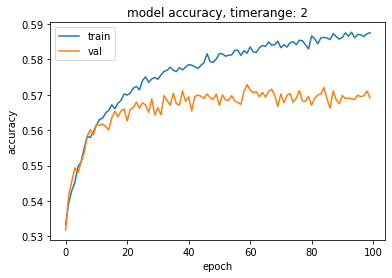

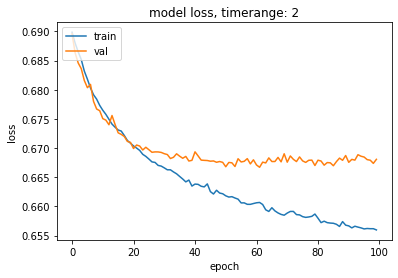

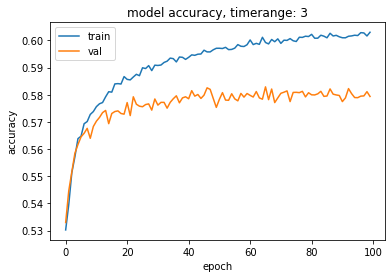

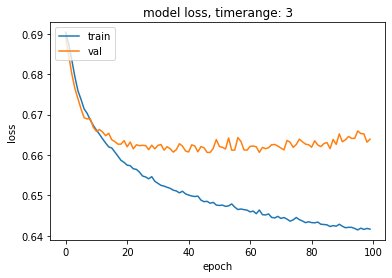

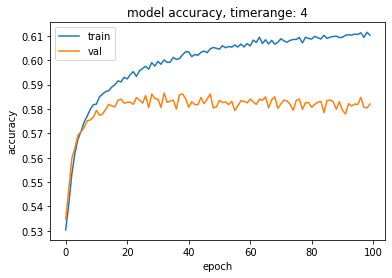

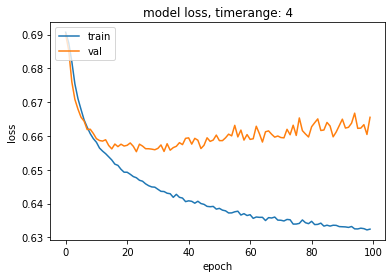

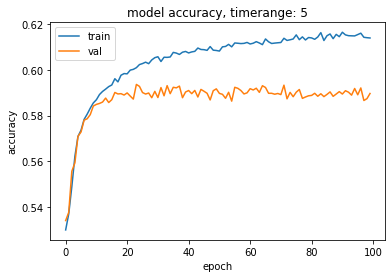

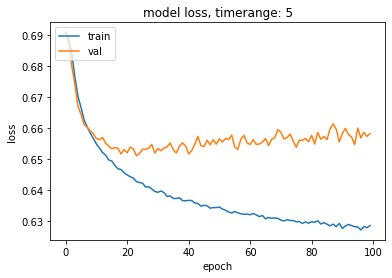

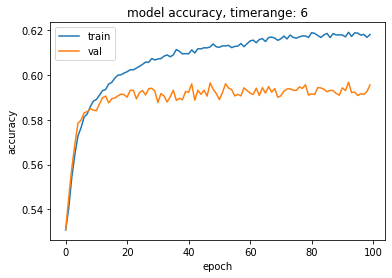

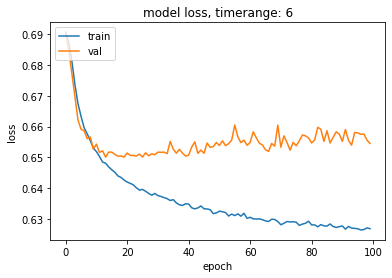

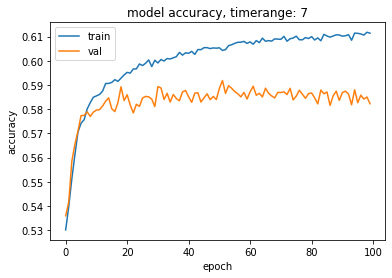

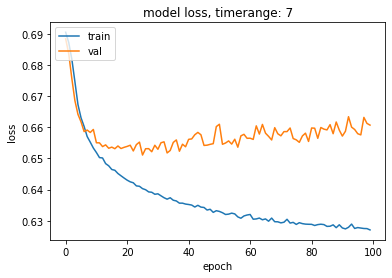

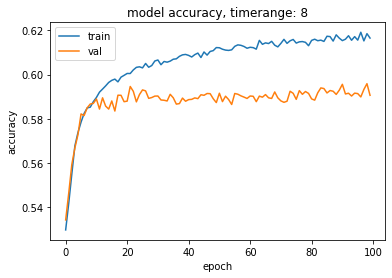

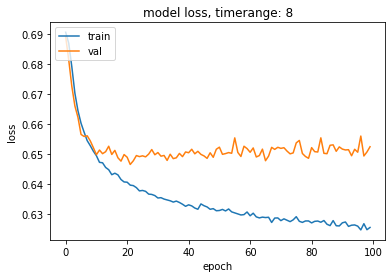

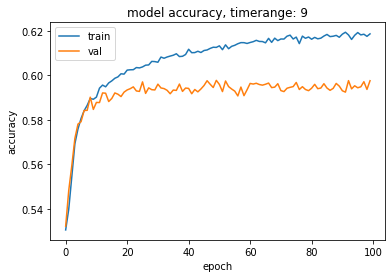

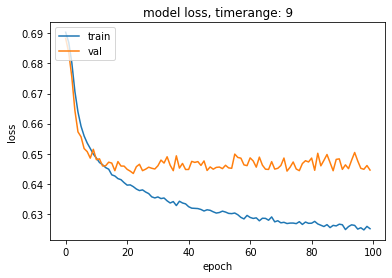

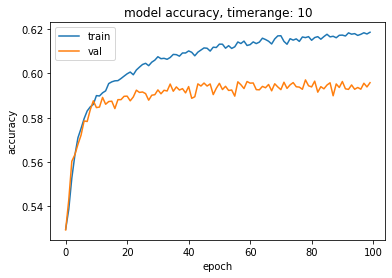

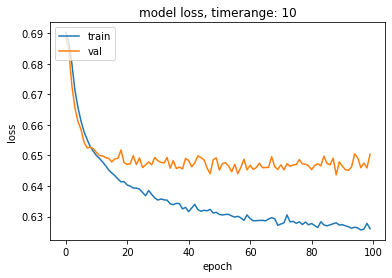

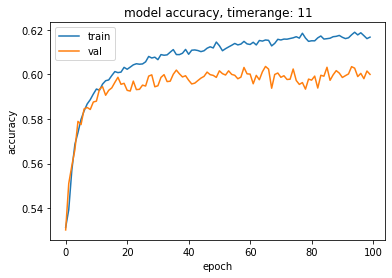

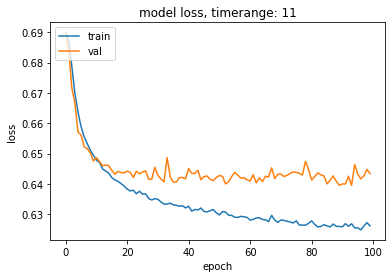

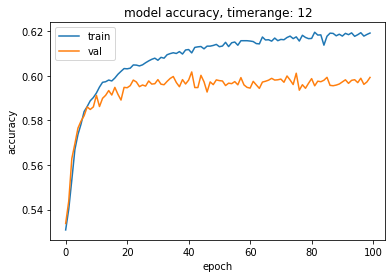

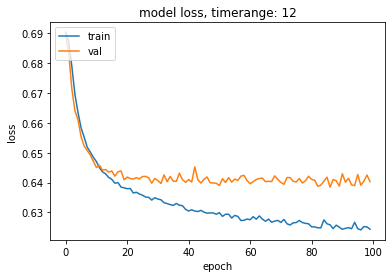

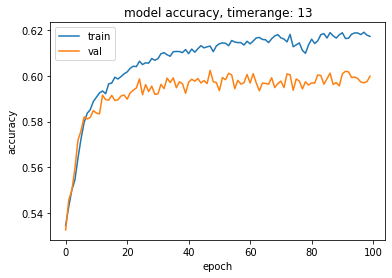

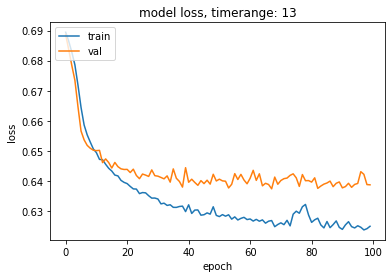

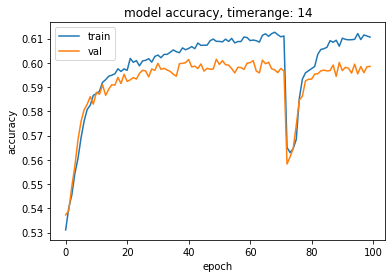

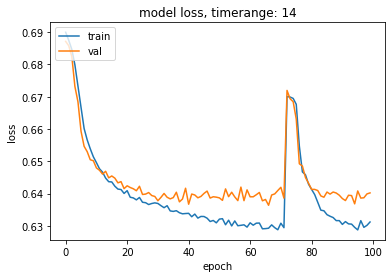

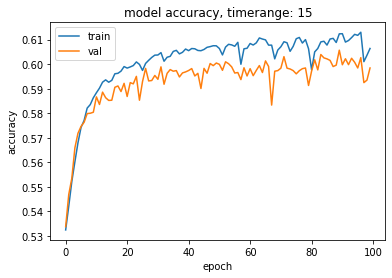

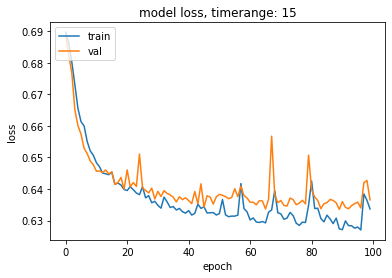

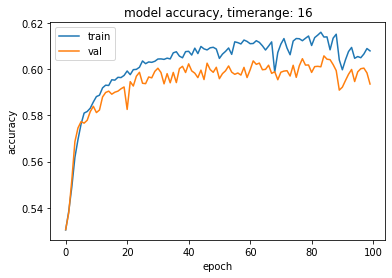

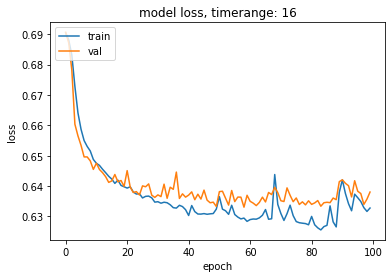

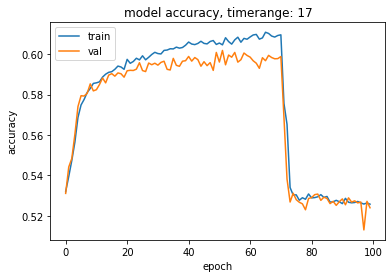

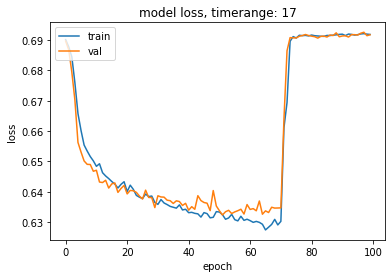

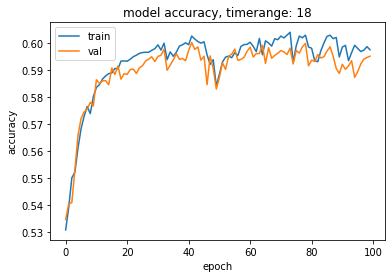

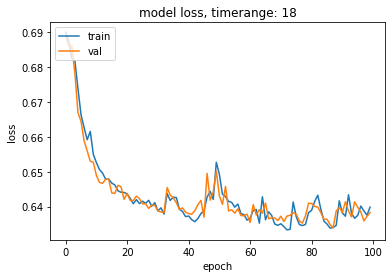

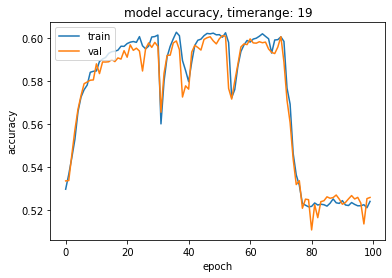

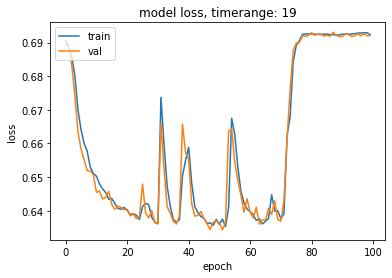

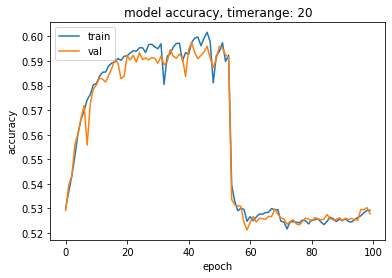

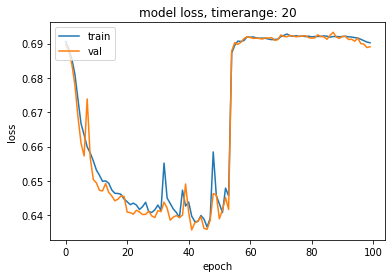

In [58]:
for tr, history in zip(range(2, 21), histories):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy, timerange: ' + str(tr))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss, timerange: ' + str(tr))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()